 # Classifica√ß√£o de Sentimentos no Dataset "Restaurant Reviews" com o Modelo DistilBERT.

### Descri√ß√£o do Dataset

Nesse trabalho, ser√° analisado um dataset que cont√©m reviews de restaurantes europeus. O dataset inclui informa√ß√µes como o o nome do restaurante, o pa√≠s em que ele est√° localizado, o sentimento da avalia√ß√£o (positivo ou negativo), o t√≠tulo da avalia√ß√£o e o conte√∫do da avalia√ß√£o.

### Bibliotecas Necess√°rias

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import os
import re
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize ,sent_tokenize
nltk.download('punkt')
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package stopwords to /home/ester/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ester/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Carregamento do Dataset



In [113]:
df=pd.read_csv("European Restaurant Reviews.csv")

 Visualiza√ß√£o do conte√∫do e da estrutura do dataset

In [114]:
df.head()

Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review Title Review Date  \
0                               Rude manager  May 2024 ‚Ä¢   
1                       A big disappointment  Feb 2024 ‚Ä¢   
2               Pretty Place with Bland Food  Nov 2023 ‚Ä¢   
3   Great service and wine but inedible food  Mar 2023 ‚Ä¢   
4  Avoid- Worst meal in Rome - possibly ever  Nov 2022 ‚Ä¢   

                                              Review  
0  The manager became agressive when I said the c...  
1  I ordered a beef fillet ask to be done medium,...  
2  This is an attractive venue with welcoming, al...  
3  Sadly I  used the high TripAdvisor rating too ...  
4  From the start this meal was bad- especially g...

Quantidade de observa√ß√µes, quantidade de dados ausentes e tipo de cada coluna

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB


Conclus√£o do carregamento

O Dataset possui 1502 observa√ß√µes com 6 colunas: Country (Pa√≠s), Restaurant Name (Nome do Restaurante), Review Title (T√≠tulo da Avalia√ß√£o), Review Date (Data da Avalia√ß√£o), Review (Avalia√ß√£o) e n√£o possui nenhum dado ausente em nenhuma das 6 colunas, portanto, n√£o ser√° necess√°ria nenhuma t√©cnica de pr√©-processamento para lidar com dados ausentes. Todas as colunas s√£o do tipo object (string).

### Informa√ß√µes do dataset

In [116]:
df.describe()

Country            Restaurant Name Sentiment Review Title Review Date  \
count     1502                       1502      1502         1502        1502   
unique       7                          7         2         1343         143   
top     France  The Frog at Bercy Village  Positive    Excellent  May 2014 ‚Ä¢   
freq       512                        512      1237            9         108   

                                                   Review  
count                                                1502  
unique                                               1426  
top     I actually never write reviews for the restaur...  
freq                                                    4

O dataset cont√©m dados de 7 restaurantes de 7 diferentes pa√≠ses.

Distribui√ß√£o de sentimentos

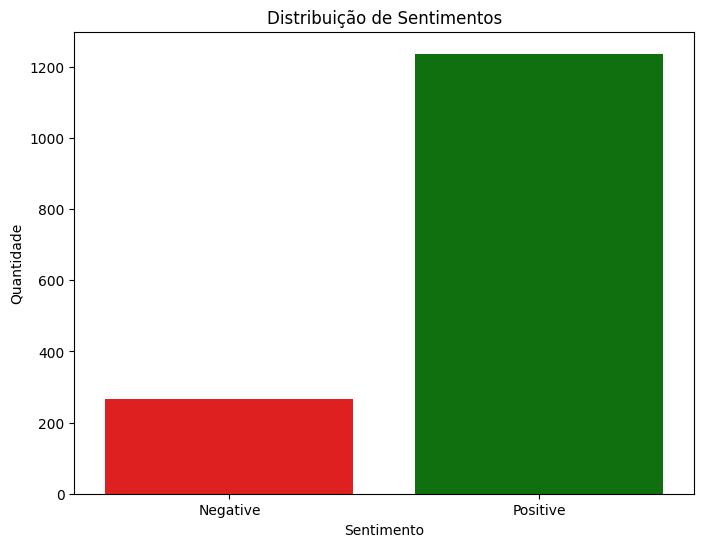

In [117]:
plt.figure(figsize=(8,6))
sns.countplot(x="Sentiment", data=df, hue="Sentiment" ,palette=['red', 'green'], legend=False) 
plt.title("Distribui√ß√£o de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

Das 1502 observa√ß√µes, 1237 s√£o positivas e 265 negativas.

M√©dia de tamanho da avalia√ß√£o de acordo com o sentimento

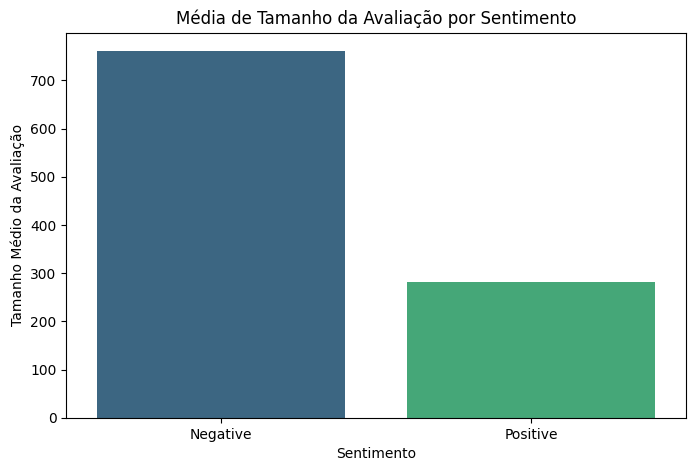

In [118]:
df['Review Length'] = df['Review'].apply(len)
avg_review_length = df.groupby('Sentiment')['Review Length'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_review_length.index, y=avg_review_length.values, hue=avg_review_length.index,palette='viridis')
plt.title('M√©dia de Tamanho da Avalia√ß√£o por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Tamanho M√©dio da Avalia√ß√£o')
plt.show()

Esse gr√°fico mostra que as avalia√ß√µes negativas tendem a ser muito mais longas do que as avalia√ß√µes positivas (As positivas costumam ter cerca de 300 caracteres, enquanto as positivas costumam ter cerca de 700 caracteres). Isso evidencia que, quando os clientes est√£o insatisfeitos, eles costumam avaliar de forma mais detalhada em compara√ß√£o a quando eles est√£o satisfeitos. Esse elemento pode ser utilizado pelo modelo de classifica√ß√£o de sentimentos para uma classifica√ß√£o mais precisa.

### Quantidade de avalia√ß√µes separadas por pa√≠s

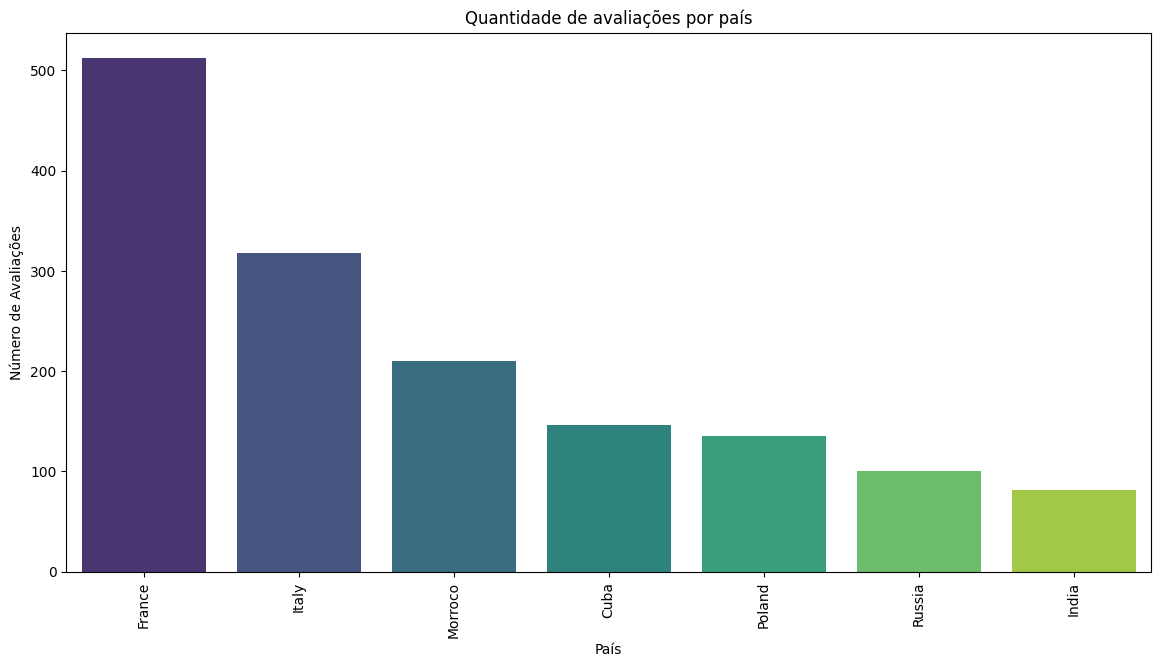

In [119]:
plt.figure(figsize=(14,7))
country_count=df["Country"].value_counts()
sns.barplot(x=country_count.index,y=country_count.values, hue=country_count.index, palette="viridis")
plt.title("Quantidade de avalia√ß√µes por pa√≠s")
plt.xlabel("Pa√≠s")
plt.ylabel("N√∫mero de Avalia√ß√µes")
plt.xticks(rotation=90)
plt.show()

### Porcentagem de cada sentimento para cada pa√≠s


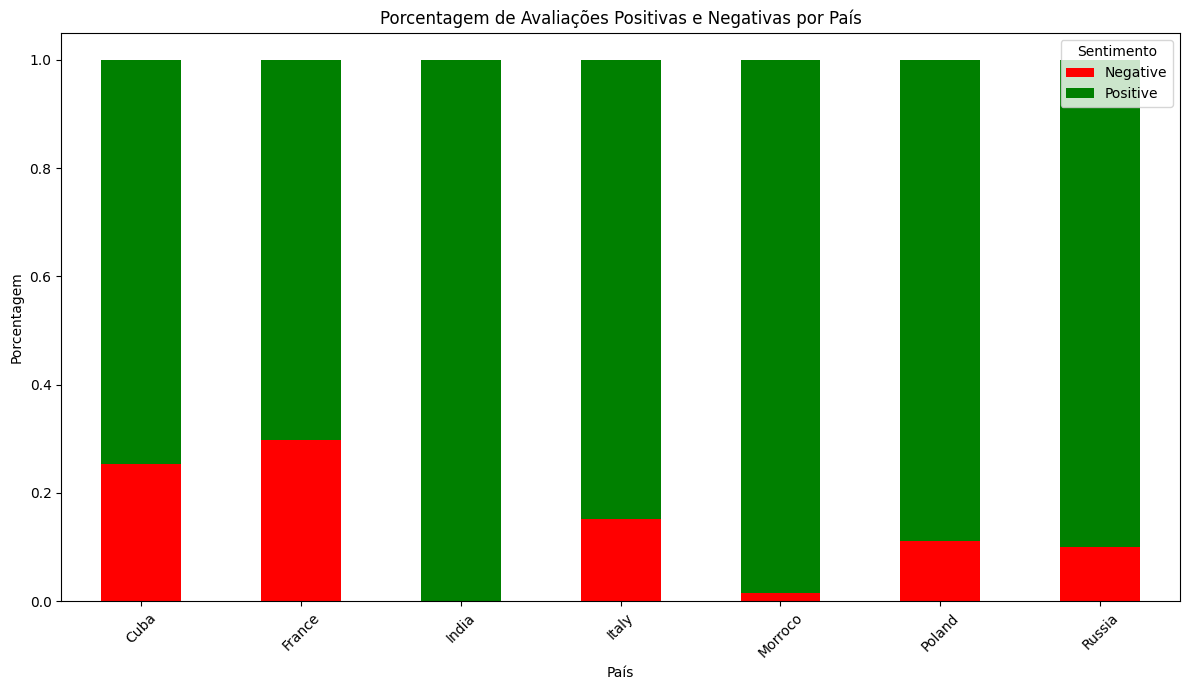

In [120]:
senti_country = df.groupby(['Country', 'Sentiment']).size().unstack(fill_value=0)

# Calcula a porcentagem de cada sentimento para cada pa√≠s
senti_country_perc = senti_country.apply(lambda x: x / x.sum(), axis=1)

# Cria o gr√°fico de barras empilhadas
senti_country_perc.plot(kind='bar', stacked=True, figsize=(12, 7),
                        color=['red', 'green'])

# Configura√ß√µes do gr√°fico
plt.title('Porcentagem de Avalia√ß√µes Positivas e Negativas por Pa√≠s')
plt.xlabel('Pa√≠s')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45)
plt.legend(title='Sentimento')
plt.tight_layout()
plt.savefig('sentiment_by_country.png')
plt.show()

### Pr√© processamento de texto

In [121]:
# Para processamento de texto

def limparTexto(text):
    # Convert to lowercase
    text = text.lower()
    # Remove commas
    text = re.sub(r',', '', text)
    # Remove single quotation marks
    text = re.sub(r'\'', '', text)
    # Remove double quotation marks
    text = re.sub(r'\"', '', text)
    # Remove opening parentheses 
    text = re.sub(r'\(', '', text)
    # Remove closing parentheses   
    text = re.sub(r'\)', '', text)
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove left double quotation marks  
    text = re.sub(r'‚Äú', '', text)
    # Remove right double quotation marks
    text = re.sub(r'‚Äù', '', text)
    # Remove right single quotation marks
    text = re.sub(r'‚Äô', '', text)
    # Remove periods
    text = re.sub(r'\.', '', text)
    # Remove semicolons
    text = re.sub(r';', '', text)
    # Remove colons 
    text = re.sub(r':', '', text)
    # Remove hyphens 
    text = re.sub(r'\-', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Return the cleaned text
    return text

In [122]:
# Aplica limparTexto na coluna 'Review'
df['cleaned_review'] = df['Review'].apply(limparTexto)
df['cleaned_review']

0       the manager became agressive when i said the c...
1       i ordered a beef fillet ask to be done medium ...
2       this is an attractive venue with welcoming alb...
3       sadly i  used the high tripadvisor rating too ...
4       from the start this meal was bad especially gi...
                              ...                        
1497    despite the other reviews saying that this is ...
1498    beer is good  food is awfull  the only decent ...
1499    for terrible service of a truly comedic level ...
1500    we visited the havanas club museum which is lo...
1501    food and service was awful very pretty stop go...
Name: cleaned_review, Length: 1502, dtype: object

In [123]:
# Remove stop words
def Remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    text = ' '.join(words)
    return text

# Aplicar o Remove_stop_words na coluna 'cleaned_review' 
df['cleaned_review'] = df['cleaned_review'].apply(Remove_stop_words)

df.head(5)

Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review Title Review Date  \
0                               Rude manager  May 2024 ‚Ä¢   
1                       A big disappointment  Feb 2024 ‚Ä¢   
2               Pretty Place with Bland Food  Nov 2023 ‚Ä¢   
3   Great service and wine but inedible food  Mar 2023 ‚Ä¢   
4  Avoid- Worst meal in Rome - possibly ever  Nov 2022 ‚Ä¢   

                                              Review  Review Length  \
0  The manager became agressive when I said the c...            146   
1  I ordered a beef fillet ask to be done medium,...            281   
2  This is an attractive venue with welcoming, al...            260   
3  Sadly I  used the high TripAdvisor rating too ...           1513   
4  From the start this meal was bad- especially g...           1351   

                                      cleaned_review  
0  manager became agressive said carbonara good r...  
1  ordered beef fillet ask done medium got well d...  
2  attractive venue welcoming albeit somewhat slo...  
3  sadly used high tripadvisor rating literally f...  
4  start meal bad especially given price visited ...

In [124]:
# Tokenizar todas as frases do cleaned_version 
df['cleaned_review_tokens'] = df['cleaned_review'].apply(lambda x: x.split())
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
display(df)

Country            Restaurant Name Sentiment  \
0     France  The Frog at Bercy Village  Negative   
1     France  The Frog at Bercy Village  Negative   
2     France  The Frog at Bercy Village  Negative   
3     France  The Frog at Bercy Village  Negative   
4     France  The Frog at Bercy Village  Negative   
...      ...                        ...       ...   
1497    Cuba   Old Square (Plaza Vieja)  Negative   
1498    Cuba   Old Square (Plaza Vieja)  Negative   
1499    Cuba   Old Square (Plaza Vieja)  Negative   
1500    Cuba   Old Square (Plaza Vieja)  Negative   
1501    Cuba   Old Square (Plaza Vieja)  Negative   

                                   Review Title Review Date  \
0                                  Rude manager  May 2024 ‚Ä¢   
1                          A big disappointment  Feb 2024 ‚Ä¢   
2                  Pretty Place with Bland Food  Nov 2023 ‚Ä¢   
3      Great service and wine but inedible food  Mar 2023 ‚Ä¢   
4     Avoid- Worst meal in Rome - possibly ever  Nov 2022 ‚Ä¢   
...                                         ...         ...   
1497                           The Tourism Trap  Oct 2016 ‚Ä¢   
1498                           the beer factory  Oct 2016 ‚Ä¢   
1499                                    brewery  Oct 2016 ‚Ä¢   
1500           It's nothing exciting over there  Oct 2016 ‚Ä¢   
1501                               Tourist Trap  Oct 2016 ‚Ä¢   

                                                 Review  Review Length  \
0     The manager became agressive when I said the c...            146   
1     I ordered a beef fillet ask to be done medium,...            281   
2     This is an attractive venue with welcoming, al...            260   
3     Sadly I  used the high TripAdvisor rating too ...           1513   
4     From the start this meal was bad- especially g...           1351   
...                                                 ...            ...   
1497  Despite the other reviews saying that this is ...            776   
1498  beer is good.  food is awfull  The only decent...            169   
1499  for terrible service of a truly comedic level,...            150   
1500  We visited the Havana's Club Museum which is l...            356   
1501  Food and service was awful. Very pretty stop. ...             76   

                                         cleaned_review  \
0     manager became agressive said carbonara good r...   
1     ordered beef fillet ask done medium got well d...   
2     attractive venue welcoming albeit somewhat slo...   
3     sadly used high tripadvisor rating literally f...   
4     start meal bad especially given price visited ...   
...                                                 ...   
1497  despite reviews saying lovely place hang espec...   
1498  beer good food awfull decent thing shish kabob...   
1499  terrible service truly comedic level 23 full p...   
1500  visited havanas club museum located old havana...   
1501  food service awful pretty stop good photos bad...   

                                  cleaned_review_tokens  
0     [manager, became, agressive, said, carbonara, ...  
1     [ordered, beef, fillet, ask, done, medium, got...  
2     [attractive, venue, welcoming, albeit, somewha...  
3     [sadly, used, high, tripadvisor, rating, liter...  
4     [start, meal, bad, especially, given, price, v...  
...                                                 ...  
1497  [despite, reviews, saying, lovely, place, hang...  
1498  [beer, good, food, awfull, decent, thing, shis...  
1499  [terrible, service, truly, comedic, level, 23,...  
1500  [visited, havanas, club, museum, located, old,...  
1501  [food, service, awful, pretty, stop, good, pho...  

[1502 rows x 9 columns]

Os pa√≠ses da parte central da Europa possuem uma quantidade maior de avalia√ß√µes, evidenciando uma poss√≠vel cultura culin√°ria mais forte nesses pa√≠ses.

Nuvem de palavras mais utilizadas em avalia√ß√µes positivas

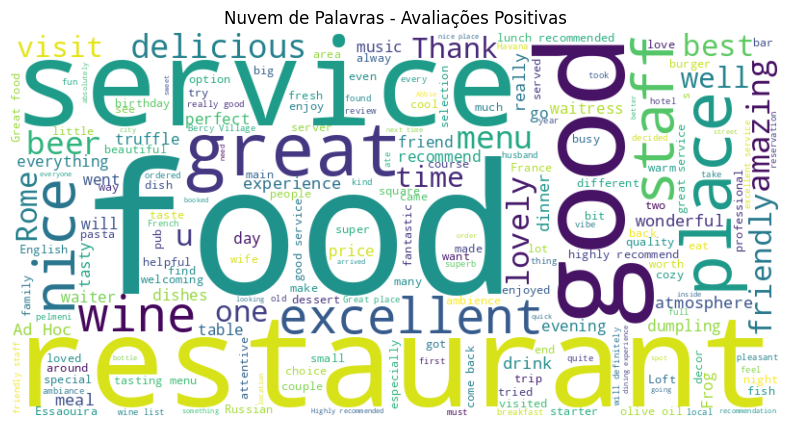

In [125]:
positive_reviews = df[df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avalia√ß√µes Positivas')
plt.axis('off')
plt.show()

Nuvem de palavras mais utilizadas em avalia√ß√µes negativas

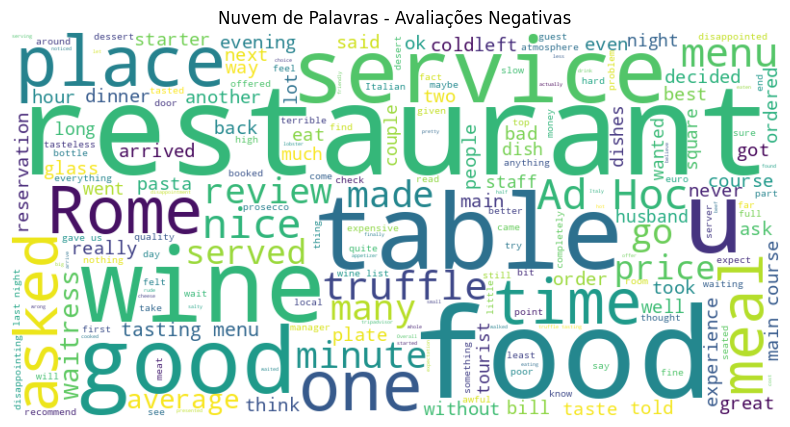

In [126]:
positive_reviews = df[df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avalia√ß√µes Negativas')
plt.axis('off')
plt.show()

As palavras mais frequentes para cada tipo de sentimento s√£o importantes informa√ß√µes para o modelo de linguagem classificar sentimentos com a maior acur√°cia poss√≠vel. Por√©m, algumas palavras podem estar igualmente presentes em grande quantidade em ambos os sentimentos, como a palavra "restaurante", por exemplo.

### M√©dia de sentimentos ao longo do tempo

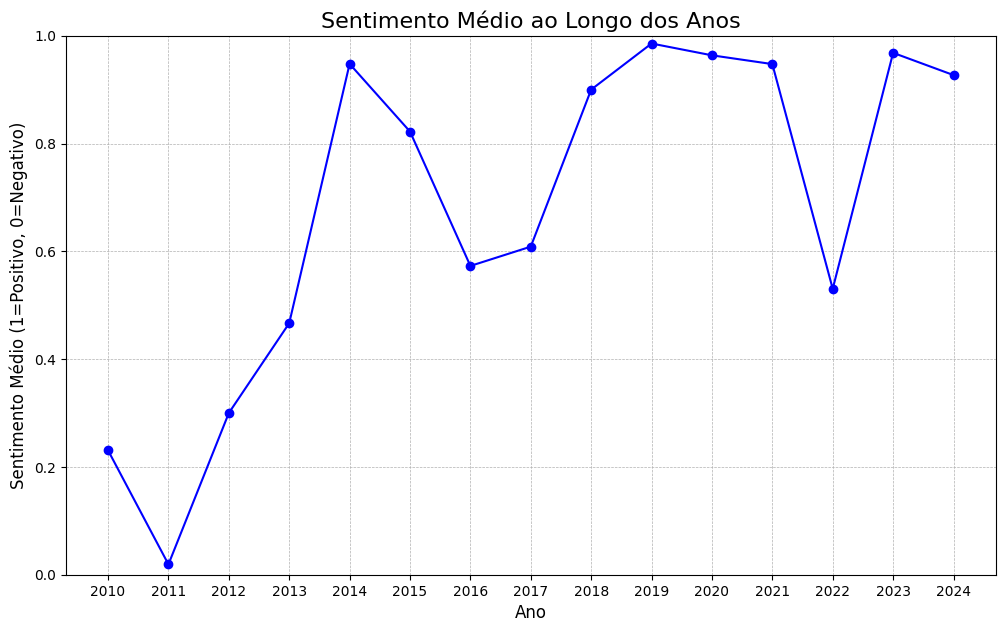

In [127]:
df_temp = df.copy()

# Extrair m√™s e ano (ex: "May 2024")
df_temp['Review Date'] = df_temp['Review Date'].str.extract(r'([A-Za-z]+\s+\d{4})')

# Corrigir abrevia√ß√£o n√£o padr√£o "Sept"
df_temp['Review Date'] = df_temp['Review Date'].str.replace('Sept', 'Sep')

# Converter para datetime (dia 1 por padr√£o)
df_temp['Review Date'] = pd.to_datetime(df_temp['Review Date'], format='%b %Y', errors='coerce')

# Mapear sentimentos para valores num√©ricos
df_temp['Sentiment_Value'] = df_temp['Sentiment'].map({'Positive': 1, 'Negative': 0})

# M√©dia de sentimento por ano
sentiment_by_year = df_temp.groupby(df_temp['Review Date'].dt.year)['Sentiment_Value'].mean()

# Plotar
plt.figure(figsize=(12, 7))
sentiment_by_year.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Sentimento M√©dio ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Sentimento M√©dio (1=Positivo, 0=Negativo)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(sentiment_by_year.index)
plt.ylim(0, 1)
plt.show()


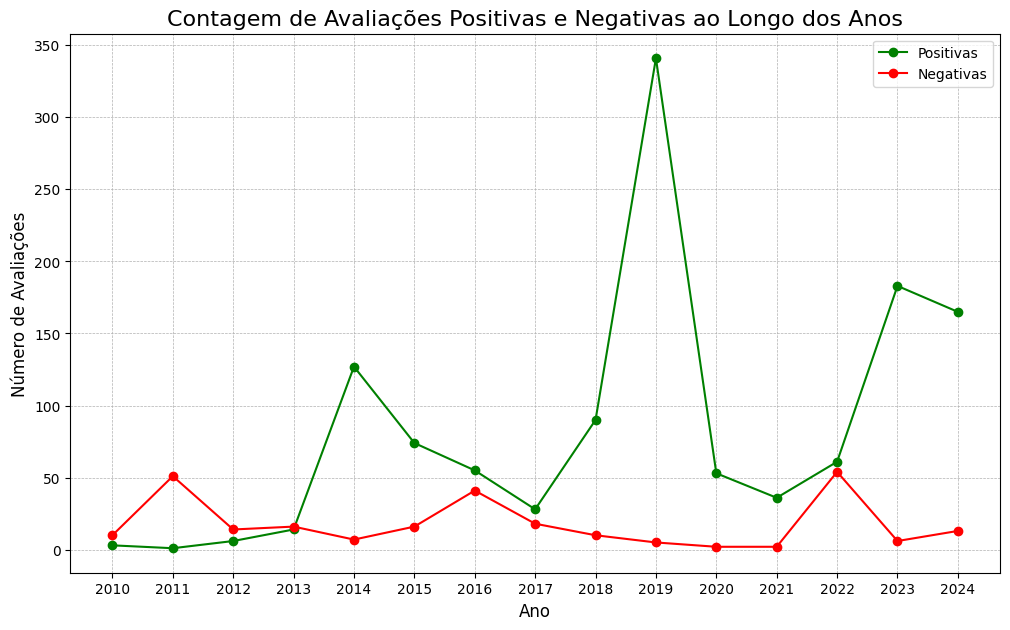

In [128]:
# 2. Extrair o ano para uma nova coluna
df_temp['Year'] = df_temp['Review Date'].dt.year

# 3. Agrupar por ano e sentimento e contar as ocorr√™ncias
# .size() conta o n√∫mero de linhas para cada grupo (ano, sentimento)
# .unstack() pivota a coluna 'Sentiment' para que 'Positive' e 'Negative' virem colunas separadas
sentiment_counts_by_year = df_temp.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 7))
plt.plot(sentiment_counts_by_year.index, sentiment_counts_by_year['Positive'], marker='o', linestyle='-', color='g', label='Positivas')
plt.plot(sentiment_counts_by_year.index, sentiment_counts_by_year['Negative'], marker='o', linestyle='-', color='r', label='Negativas')
plt.title('Contagem de Avalia√ß√µes Positivas e Negativas ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('N√∫mero de Avalia√ß√µes', fontsize=12)
plt.xticks(sentiment_counts_by_year.index.astype(int)) # Garante que os anos sejam inteiros no eixo
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend() # Adiciona a legenda para identificar as linhas
plt.show()

## Aplicando o modelo Distilbert

In [129]:
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

def predict_sentiment(texts):
    # Processa em batches para evitar uso excessivo de mem√≥ria, aproveita melhor o hardware
    batch_size = 8 # Lotes de 8 textos
    sentiment_map = {0: "Muito Negativo", 1: "Negativo", 2: "Neutro", 3: "Positivo", 4: "Muito Positivo"}
    all_preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).tolist()
        all_preds.extend([sentiment_map[p] for p in preds])
    return all_preds

resultados = predict_sentiment(texts)

for original, processed, sentiment in zip(df['Review'], texts, resultados):
    print(f"Texto original:\n{original}")
    print(f"Texto processado:\n{processed}")
    print(f"Sentimento: {sentiment}")
    print("-" * 80)


Texto original:
The manager became agressive when I said the carbonara was not good. She was rude. It was  a very bad experience. The worst in Rome in many years.
Texto processado:
manager became agressive said carbonara good rude bad experience worst rome many years
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price.
Texto processado:
ordered beef fillet ask done medium got well done cooked dry told took steak 20 minutes brought another steak completely rare left steak asked charged fool price
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
This is an attractive 

Acrescentando a coluna com os sentimentos atribu√≠dos pelo Distilbert

In [130]:
df["sentiment_distilbert"] = resultados
df.to_csv("European_Restaurant_Reviews_with_Sentiment.csv", index=False)
display(df)

Country            Restaurant Name Sentiment  \
0     France  The Frog at Bercy Village  Negative   
1     France  The Frog at Bercy Village  Negative   
2     France  The Frog at Bercy Village  Negative   
3     France  The Frog at Bercy Village  Negative   
4     France  The Frog at Bercy Village  Negative   
...      ...                        ...       ...   
1497    Cuba   Old Square (Plaza Vieja)  Negative   
1498    Cuba   Old Square (Plaza Vieja)  Negative   
1499    Cuba   Old Square (Plaza Vieja)  Negative   
1500    Cuba   Old Square (Plaza Vieja)  Negative   
1501    Cuba   Old Square (Plaza Vieja)  Negative   

                                   Review Title Review Date  \
0                                  Rude manager  May 2024 ‚Ä¢   
1                          A big disappointment  Feb 2024 ‚Ä¢   
2                  Pretty Place with Bland Food  Nov 2023 ‚Ä¢   
3      Great service and wine but inedible food  Mar 2023 ‚Ä¢   
4     Avoid- Worst meal in Rome - possibly ever  Nov 2022 ‚Ä¢   
...                                         ...         ...   
1497                           The Tourism Trap  Oct 2016 ‚Ä¢   
1498                           the beer factory  Oct 2016 ‚Ä¢   
1499                                    brewery  Oct 2016 ‚Ä¢   
1500           It's nothing exciting over there  Oct 2016 ‚Ä¢   
1501                               Tourist Trap  Oct 2016 ‚Ä¢   

                                                 Review  Review Length  \
0     The manager became agressive when I said the c...            146   
1     I ordered a beef fillet ask to be done medium,...            281   
2     This is an attractive venue with welcoming, al...            260   
3     Sadly I  used the high TripAdvisor rating too ...           1513   
4     From the start this meal was bad- especially g...           1351   
...                                                 ...            ...   
1497  Despite the other reviews saying that this is ...            776   
1498  beer is good.  food is awfull  The only decent...            169   
1499  for terrible service of a truly comedic level,...            150   
1500  We visited the Havana's Club Museum which is l...            356   
1501  Food and service was awful. Very pretty stop. ...             76   

                                         cleaned_review  \
0     manager became agressive said carbonara good r...   
1     ordered beef fillet ask done medium got well d...   
2     attractive venue welcoming albeit somewhat slo...   
3     sadly used high tripadvisor rating literally f...   
4     start meal bad especially given price visited ...   
...                                                 ...   
1497  despite reviews saying lovely place hang espec...   
1498  beer good food awfull decent thing shish kabob...   
1499  terrible service truly comedic level 23 full p...   
1500  visited havanas club museum located old havana...   
1501  food service awful pretty stop good photos bad...   

                                  cleaned_review_tokens sentiment_distilbert  
0     [manager, became, agressive, said, carbonara, ...       Muito Negativo  
1     [ordered, beef, fillet, ask, done, medium, got...       Muito Negativo  
2     [attractive, venue, welcoming, albeit, somewha...               Neutro  
3     [sadly, used, high, tripadvisor, rating, liter...       Muito Positivo  
4     [start, meal, bad, especially, given, price, v...             Negativo  
...                                                 ...                  ...  
1497  [despite, reviews, saying, lovely, place, hang...               Neutro  
1498  [beer, good, food, awfull, decent, thing, shis...               Neutro  
1499  [terrible, service, truly, comedic, level, 23,...       Muito Negativo  
1500  [visited, havanas, club, museum, located, old,...               Neutro  
1501  [food, service, awful, pretty, stop, good, pho...             Negativo  

[1502 rows x 10 columns]

### An√°lise da Acur√°cia
Verificando os acertos do modelo

In [131]:
# R√≥tulos verdadeiros originais (ex: ['Positive', 'Negative', ...])
y_true_original = df['Sentiment'].tolist()

# R√≥tulos preditos, com 5 classes (ex: ['Positivo', 'Neutro', ...])
y_pred_original_5_classes = resultados

# Retirando o r√≥tulo "Neutro"
mapa_simplificado = {
    "Muito Negativo": "Negative",
    "Negativo": "Negative",
    "Positivo": "Positive",
    "Muito Positivo": "Positive"
}

y_true_filtrado = []
y_pred_filtrado_e_simplificado = []

for verdadeiro, predito_5_classes in zip(y_true_original, y_pred_original_5_classes):    
    if predito_5_classes == "Neutro":
        continue
    y_true_filtrado.append(verdadeiro)
    y_pred_filtrado_e_simplificado.append(mapa_simplificado[predito_5_classes])


removidos = len(y_true_original) - len(y_true_filtrado)
print(f"Foram removidas {removidos} predi√ß√µes classificadas como 'Neutro'.")
print(f"Avaliando em um total de {len(y_true_filtrado)} amostras.")
print("-" * 50)

print("\nRelat√≥rio de Classifica√ß√£o (sem as predi√ß√µes 'Neutro'):")
print(classification_report(y_true_filtrado, y_pred_filtrado_e_simplificado))

Foram removidas 279 predi√ß√µes classificadas como 'Neutro'.
Avaliando em um total de 1223 amostras.
--------------------------------------------------

Relat√≥rio de Classifica√ß√£o (sem as predi√ß√µes 'Neutro'):
              precision    recall  f1-score   support

    Negative       0.95      0.86      0.90       169
    Positive       0.98      0.99      0.99      1054

    accuracy                           0.97      1223
   macro avg       0.96      0.93      0.94      1223
weighted avg       0.97      0.97      0.97      1223



Com uma acur√°cia geral de 97%, o modelo erra muito pouco. A cada 100 avalia√ß√µes que o modelo analisou, ele acertou o sentimento de 97. 
Quando avalia uma classifica√ß√£o como negativa, acerta em 95% das vezes. Quando avalia como positiva, acerta em 98% das vezes.

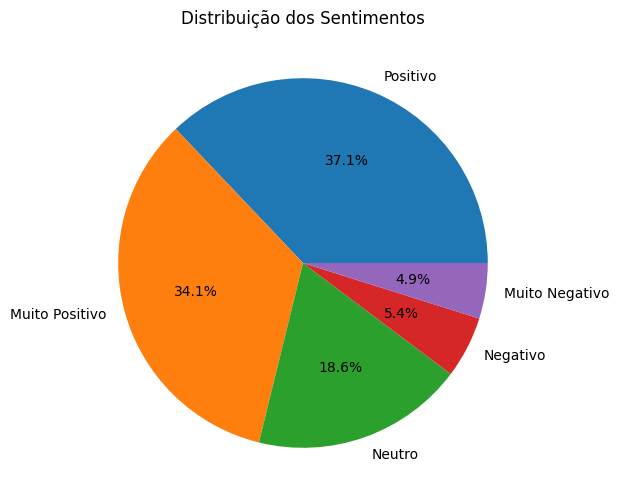

In [133]:
plt.figure(figsize=(10, 6))
plt.pie(df['sentiment_distilbert'].value_counts(), labels=df['sentiment_distilbert'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribui√ß√£o dos Sentimentos')
plt.show()

## Clusteriza√ß√£o Sem√¢ntica
O objetivo √© agrupar as avalia√ß√µes em temas, com base em seu significado contextual, capturado pelos embeddings do modelo Transformer.

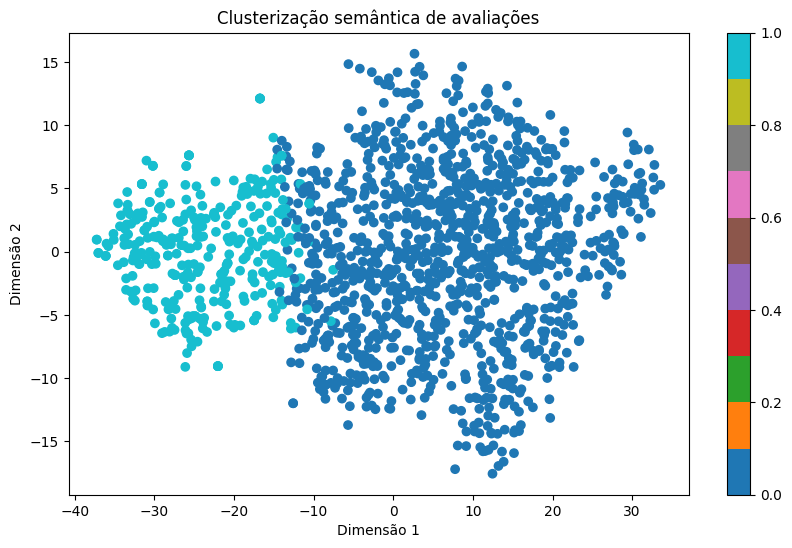

In [134]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model2 = AutoModel.from_pretrained(model_name)

model2.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

def get_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            outputs = model2(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # [CLS] token
            embeddings.append(cls_embedding)
    return embeddings


df = pd.read_csv("European_Restaurant_Reviews_with_Sentiment.csv")
df['full_review'] = df['Review Title'].fillna('') + ' . ' + df['cleaned_review'].fillna('')
texts = df['full_review'].tolist()

embeddings = get_embeddings(texts)  # texts = lista de textos processados
embeddings = np.array(embeddings).astype(np.float64)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Adiciona ao dataframe
df['cluster'] = clusters

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10')
plt.title("Clusteriza√ß√£o sem√¢ntica de avalia√ß√µes")
plt.xlabel("Dimens√£o 1")
plt.ylabel("Dimens√£o 2")
plt.colorbar()
plt.show()

In [135]:
df['cluster'] = clusters
print(df['cleaned_review_tokens'].head())

0    ['manager', 'became', 'agressive', 'said', 'ca...
1    ['ordered', 'beef', 'fillet', 'ask', 'done', '...
2    ['attractive', 'venue', 'welcoming', 'albeit',...
3    ['sadly', 'used', 'high', 'tripadvisor', 'rati...
4    ['start', 'meal', 'bad', 'especially', 'given'...
Name: cleaned_review_tokens, dtype: object


Nessa etapa, encontramos as palavras que mais influenciam cada cluster. Elas ajudam a entender o "tema" de cada grupo de avalia√ß√µes.

A vetoriza√ß√£o TF-IDF mede a import√¢ncia de uma palavra em uma avalia√ß√£o espec√≠fica, e em rela√ß√£o a todas as outras avalia√ß√µes.

Al√©m de algumas stopwords pr√© definidas, selecionamos algumas que, na nossa opini√£o, n√£o influenciaram na sele√ß√£o dos clusters.

In [136]:
minhas_stopwords_adicionais = ['great', 'didnt', 'service', 'like', 'good', 'place', 'nice', 'restaurant', 'food', 'rome']
stopwords_finais = list(ENGLISH_STOP_WORDS.union(minhas_stopwords_adicionais))


vectorizer = TfidfVectorizer(stop_words=stopwords_finais)
tfidf_matriz = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

#Encontrando as palavras mais influentes de cada cluster
n_palavras = 10
for i in range(kmeans.n_clusters):
    print(f"--- Cluster {i} ---")

    #apenas avalia√ß√µes do cluster i
    indice_cluster = df[df['cluster'] == i].index

    soma_scores = tfidf_matriz[indice_cluster].sum(axis=0)

    scores_array = np.asarray(soma_scores).flatten()
    #Selecionando as palavras com mas score
    top_indices = scores_array.argsort()[:-n_palavras-1:-1]

    top_words = [feature_names[idx] for idx in top_indices]
    print(', '.join(top_words))
    print()

--- Cluster 0 ---
excellent, amazing, delicious, friendly, best, staff, atmosphere, really, lovely, wine

--- Cluster 1 ---
wine, table, menu, meal, reservation, bad, terrible, asked, took, time



Analisando os resultados obtidos em cada cluster, observamos uma poss√≠vel divis√£o entre avalia√ß√µes positivas (cluster 0) e avalia√ß√µes negativas (cluster 1)

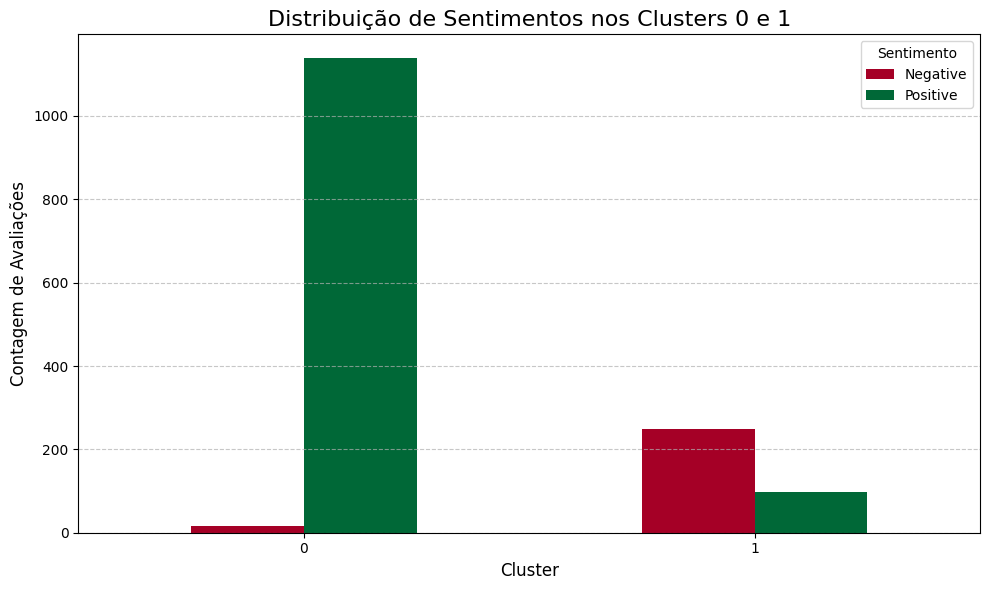

In [137]:
counts = df.groupby('cluster')['Sentiment'].value_counts()

plot_data = counts.unstack()
plot_data.plot(kind='bar', figsize=(10, 6), colormap='RdYlGn')

plt.title('Distribui√ß√£o de Sentimentos nos Clusters 0 e 1', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Contagem de Avalia√ß√µes', fontsize=12)
plt.xticks(rotation=0) # Mant√©m os r√≥tulos do eixo x na horizontal
plt.legend(title='Sentimento')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona uma grade para melhor leitura
plt.tight_layout() # Ajusta o layout para evitar que os r√≥tulos se sobreponham

plt.show()

Essa divis√£o ficou bem n√≠tida, principalmente no cluster 0, no qual pouqu√≠simas avalia√ß√µes foram calssificadas como negativas.

## Testando o modelo para novas avalia√ß√µes

In [138]:
novas_avaliacoes = [
    "Servi√ßo espetacular e a comida estava simplesmente perfeita. Uma noite memor√°vel!",
    "O melhor bacalhau que j√° comi em Lisboa. Ambiente acolhedor e pre√ßo justo.",
    "Adorei a decora√ß√£o e a m√∫sica ambiente. Um lugar com uma vibe √≥tima para ir com amigos.",
    "Esperamos mais de uma hora pela comida, que ainda por cima chegou fria. Decepcionante.",
    "O gar√ßom foi extremamente rude e parecia com pressa para nos expulsar. Nunca mais ponho os p√©s aqui.",
    "Comida sem sabor e absurdamente cara pelo que oferece. N√£o vale a pena.",
    "A localiza√ß√£o √© excelente e o prato principal estava bom, mas a sobremesa parecia velha e o caf√© estava horr√≠vel.",
    "Gostei da comida, mas o barulho era tanto que mal conseguia conversar com a pessoa √† minha frente.",
    "O card√°pio tem op√ß√µes vegetarianas e o restaurante abre para almo√ßo aos domingos.",
    "Sem d√∫vida, uma das melhores experi√™ncias gastron√¥micas que j√° tive. Cada detalhe foi pensado. Fant√°stico!",
    "The atmosphere was magical, with a beautiful view of the city. Highly recommended for a special occasion.",
    "From start to finish, the service was attentive without being intrusive. The steak was cooked to perfection.",
    "A hidden gem! The prices are very reasonable for the quality of food you get. We will be back.",
    "The place was dirty, our table was sticky and there were flies everywhere. We left before ordering.",
    "I ordered the seafood pasta and it was completely tasteless, just a watery sauce. A huge letdown.",
    "They got our order wrong twice and didn't even apologize. The staff seemed completely overwhelmed and disorganized.",
    "The pizza itself was decent, but they charge extra for every single topping, making it surprisingly expensive.",
    "Great location and a very cool interior design, but the cocktails were weak and overpriced.",
    "The restaurant has free Wi-Fi and accepts all major credit card payments.",
    "Every dish was a work of art, both visually and in terms of flavor. An absolute must-visit for any foodie."
]

previsoes_sentimento = predict_sentiment(novas_avaliacoes)

embeddings_novos = get_embeddings(novas_avaliacoes)
previsoes_cluster = kmeans.predict(embeddings_novos)

print("\n--- An√°lise Combinada: Sentimento e Cluster ---")
for i, (avaliacao, sentimento, cluster) in enumerate(zip(novas_avaliacoes, previsoes_sentimento, previsoes_cluster), 1):
    print(f"--- Avalia√ß√£o {i} ---")
    print(f"Texto   : {avaliacao}")
    print(f"Sentimento: {sentimento}")
    print(f"Cluster   : {cluster}\n")


--- An√°lise Combinada: Sentimento e Cluster ---
--- Avalia√ß√£o 1 ---
Texto   : Servi√ßo espetacular e a comida estava simplesmente perfeita. Uma noite memor√°vel!
Sentimento: Muito Positivo
Cluster   : 0

--- Avalia√ß√£o 2 ---
Texto   : O melhor bacalhau que j√° comi em Lisboa. Ambiente acolhedor e pre√ßo justo.
Sentimento: Muito Positivo
Cluster   : 0

--- Avalia√ß√£o 3 ---
Texto   : Adorei a decora√ß√£o e a m√∫sica ambiente. Um lugar com uma vibe √≥tima para ir com amigos.
Sentimento: Positivo
Cluster   : 0

--- Avalia√ß√£o 4 ---
Texto   : Esperamos mais de uma hora pela comida, que ainda por cima chegou fria. Decepcionante.
Sentimento: Positivo
Cluster   : 1

--- Avalia√ß√£o 5 ---
Texto   : O gar√ßom foi extremamente rude e parecia com pressa para nos expulsar. Nunca mais ponho os p√©s aqui.
Sentimento: Muito Negativo
Cluster   : 1

--- Avalia√ß√£o 6 ---
Texto   : Comida sem sabor e absurdamente cara pelo que oferece. N√£o vale a pena.
Sentimento: Muito Negativo
Cluster   : 1

--